In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def show_image(title, image):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def crop_barcode(image_path, output_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Apply edge detection
    edged = cv2.Canny(blurred, 50, 200, 255)

    # Apply morphological operations to close gaps in the edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

    # Show the edged image
    show_image("Edged Image", edged)
    show_image("Closed Image", closed)

    # Find contours in the closed image
    contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort the contours by area, keeping only the largest one
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    barcode_contour = None

    # Loop over the contours to find the one that likely represents the barcode
    for contour in contours:
        # Approximate the contour
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # If the approximated contour has four points, we can assume we have found the barcode
        if len(approx) == 4:
            barcode_contour = approx
            break

    if barcode_contour is not None:
        # Get the points of the contour (in order of top-left, top-right, bottom-right, bottom-left)
        points = barcode_contour.reshape(4, 2)

        # Order the points in a consistent way
        points = sorted(points, key=lambda x: x[0])
        (tl, tr) = sorted(points[:2], key=lambda x: x[1])  # top-left, top-right
        (bl, br) = sorted(points[2:], key=lambda x: x[1])  # bottom-left, bottom-right

        # The ordered points for the perspective transform
        ordered_points = np.array([tl, tr, br, bl], dtype="float32")

        # Define the width and height of the new image (horizontal rectangle)
        width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
        height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

        # Define the destination points for the perspective transform (a rectangular region)
        destination_points = np.array([
            [0, 0],
            [width - 1, 0],
            [width - 1, height - 1],
            [0, height - 1]
        ], dtype="float32")

        # Compute the perspective transform matrix
        matrix = cv2.getPerspectiveTransform(ordered_points, destination_points)

        # Apply the perspective transform to straighten the barcode region
        straightened_image = cv2.warpPerspective(image, matrix, (width, height))

        # Check if the image is taller than it is wide
        if straightened_image.shape[0] > straightened_image.shape[1]:
            # Rotate the image to make it horizontal (counterclockwise rotation)
            straightened_image = cv2.rotate(straightened_image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Show the straightened barcode
        show_image("Straightened Barcode", straightened_image)

        # Save the straightened image
        cv2.imwrite(output_path, straightened_image)
        print(f"Straightened image saved to {output_path}")
    else:
        print("No barcode detected")

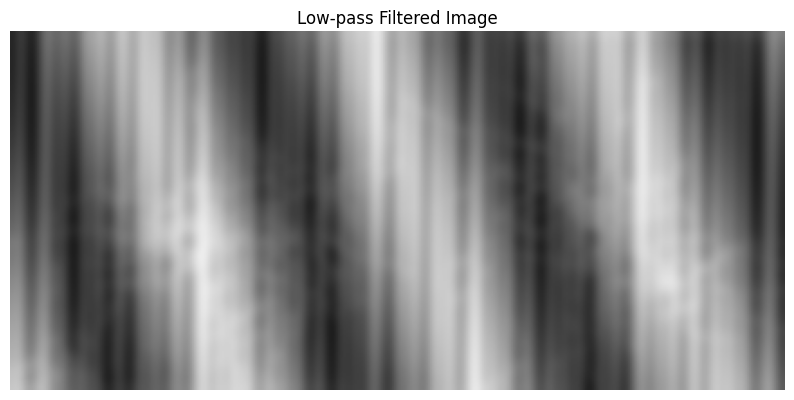

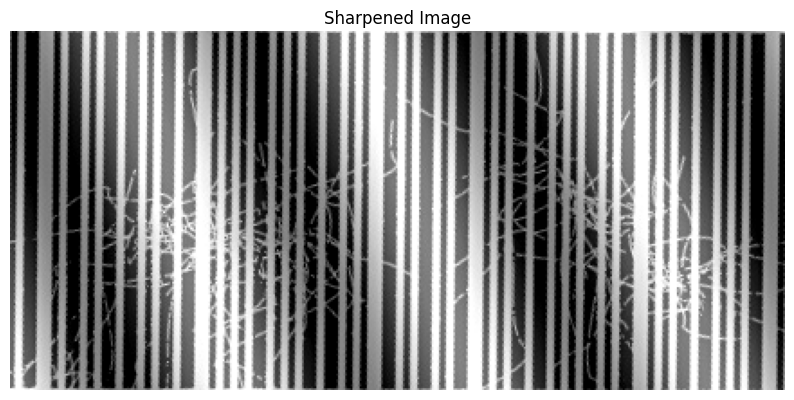

In [25]:
#take the image in cropped_image go frequncy low pass back spatial then sharpening

def low_pass_filter(image_path, output_path):

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a low-pass filter to the image
    low_pass = cv2.GaussianBlur(gray, (21, 21), 0)

    # Apply sharpening to the image
    sharpened = cv2.addWeighted(gray, 1.5, low_pass, -0.5, 0)

    # Show the low-pass and sharpened images
    show_image("Low-pass Filtered Image", low_pass)
    show_image("Sharpened Image", sharpened)

low_pass_filter("cropped_image.jpg", "sharpened_image.jpg")



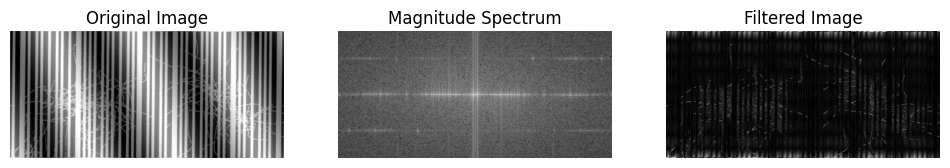

In [49]:


def frequency_domain(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return

    # Apply Discrete Fourier Transform
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    
    # Compute magnitude spectrum for visualization
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    # Frequency filtering: remove everything except vertical frequencies
  
    
    #remove horizontal frequencies
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    fshift[crow - 4:crow + 4, :] = 0

    # Apply Inverse Discrete Fourier Transform
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)



    # Display results
    plt.figure(figsize=(12, 6))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Magnitude spectrum
    plt.subplot(1, 3, 2)
    plt.title("Magnitude Spectrum")
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.axis('off')
    
    # Reconstructed image
    plt.subplot(1, 3, 3)
    plt.title("Filtered Image")
    plt.imshow(img_back, cmap='gray')
    plt.axis('off')
    
    plt.show()

# Test the function with your image
frequency_domain("cropped_image.jpg")


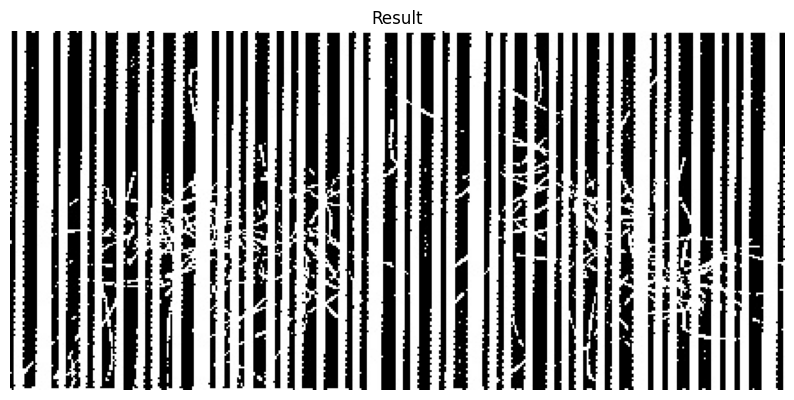

Result saved to fixed_image.jpg


In [52]:
#detect if an image has vertical line breaks and fix it plz

def fix_vertical_lines(image_path, output_path):


    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return

    # Apply adaptive thresholding to binarize the image
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -2)

    # Invert the binary image
    binary = cv2.bitwise_not(binary)

    # Detect vertical lines in the image
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    detected_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=1)

    # Remove the detected lines from the image
    result = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(detected_lines))

    # Display the result
    show_image("Result", result)

    # Save the result
    cv2.imwrite(output_path, result)
    print(f"Result saved to {output_path}")


fix_vertical_lines("thresholded_image.jpg", "fixed_image.jpg")


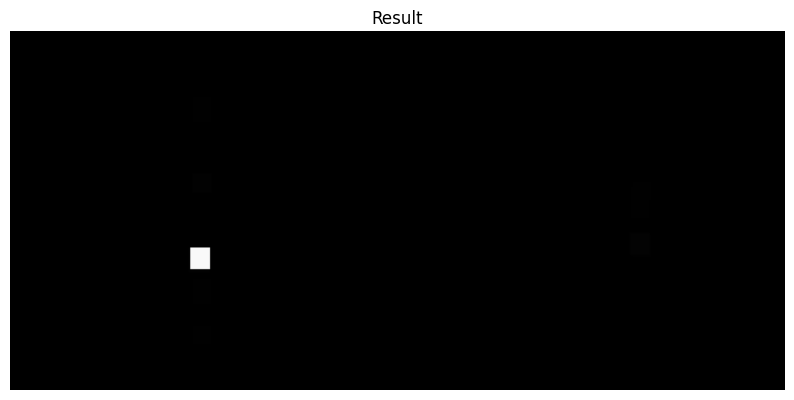

Result saved to filled_image.jpg


In [ ]:
#apply vertical median filter to the image
def vertical_median_filter(image_path, output_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image from {image_path}")
        return

    # Apply a vertical median filter to the image
    kernel = np.ones((50, 50), np.uint8)
    filtered_image = cv2.medianBlur(image, (1,9),5)

    # Display the filtered image
    show_image("Filtered Image", filtered_image)

    # Save the filtered image
    cv2.imwrite(output_path, filtered_image)
    print(f"Filtered image saved to {output_path}")

#vertical_median_filter("fixed_image.jpg", "filtered_image.jpg")

#invert the image then region fill then invert back




